Files already downloaded and verified
Files already downloaded and verified

Using Predictor: SplitPredictor, Score Function: THR

Using Predictor: SplitPredictor, Score Function: APS

Using Predictor: SplitPredictor, Score Function: SAPS

Using Predictor: SplitPredictor, Score Function: RAPS

Using Predictor: ClusterPredictor, Score Function: THR

Using Predictor: ClusterPredictor, Score Function: APS

Using Predictor: ClusterPredictor, Score Function: SAPS

Using Predictor: ClusterPredictor, Score Function: RAPS

Using Predictor: ClassWisePredictor, Score Function: THR

Using Predictor: ClassWisePredictor, Score Function: APS

Using Predictor: ClassWisePredictor, Score Function: SAPS

Using Predictor: ClassWisePredictor, Score Function: RAPS
Coverage Rate Table:
+--------------------+--------+--------+--------+--------+
| Predictor          |    APS |   RAPS |   SAPS |    THR |
+====================+========+========+========+========+
| ClassWisePredictor | 0.9056 | 0.9069 | 0.9926 

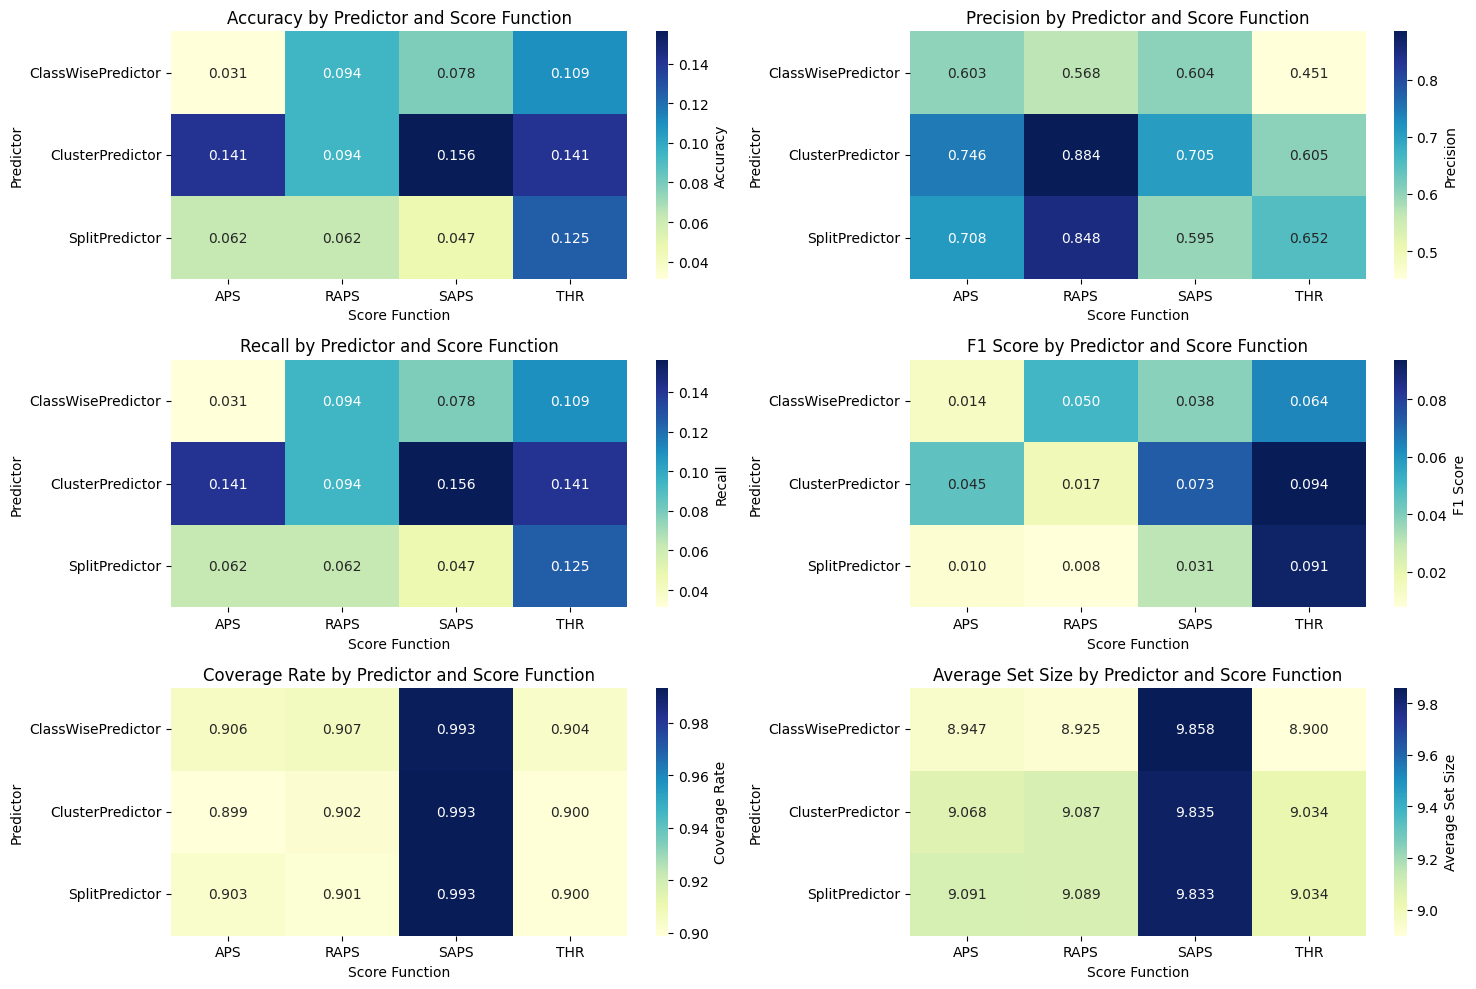

In [2]:
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=64, shuffle=True, num_workers=2)

cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_test_dataloader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Define your model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64 * 32 * 32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class SAPS(nn.Module):
    def __init__(self, weight):
        super(SAPS, self).__init__()
        if torch.any(weight <= 0):
            raise ValueError("The parameter 'weight' must be a positive value for all elements.")
        self.__weight = weight

    def forward(self, raw_scores, labels=None):
        if labels is not None:
            # Convert labels to one-hot encoding
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=raw_scores.shape[1])
            if raw_scores.shape != labels_one_hot.shape:
                print("Warning: raw_scores and labels have different shapes.")
            weighted_scores = raw_scores * self.__weight
            saps_score = torch.sum(weighted_scores, dim=1)
            return saps_score
        else:
            # If labels are not provided, return the raw scores
            return raw_scores    

model = MyModel()
model.eval()

# Specify different predictors and score functions
predictors = [SplitPredictor, ClusterPredictor, ClassWisePredictor]
score_functions = [THR(), APS(), SAPS(weight=torch.ones((10,))), RAPS(penalty=0.1)]
results = []

# Loop through different combinations for CIFAR-10
for predictor_class in predictors:
    for score_function in score_functions:
        print(f"\nUsing Predictor: {predictor_class.__name__}, Score Function: {score_function.__class__.__name__}")
        
        # Create the predictor
        predictor = predictor_class(score_function=score_function, model=model)
        
        # Calibrate the predictor with a significance level of 0.1
        try:
            predictor.calibrate(cifar10_train_dataloader, alpha=0.1)
        except Exception as e:
            print(f"Calibration failed: {e}")
            continue
        
        # Predict for test instances on CIFAR-10
        test_instances_cifar10 = torch.randn((64, 3, 32, 32))
        predict_sets_cifar10 = predictor.predict(test_instances_cifar10)
        
        # Pad the sequences to make them of equal length
        max_seq_length = max(len(seq) for seq in predict_sets_cifar10)

        
        predict_sets_cifar10_tensor = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in predict_sets_cifar10], batch_first=True, padding_value=0)
        
        # Evaluate coverage rate and average set size on CIFAR-10
        result_dict_cifar10 = predictor.evaluate(cifar10_test_dataloader)
        
        # Assuming multi-class classification
        labels = torch.randint(0, 10, (64,))  # Replace with your actual multi-class labels
        
        # Predicted Labels
        predicted_labels = torch.argmax(predict_sets_cifar10_tensor, dim=1)
        
        # Calculate accuracy, precision, recall, and F1 score
        accuracy = accuracy_score(labels.numpy(), predicted_labels.numpy())
        precision = precision_score(labels.numpy(), predicted_labels.numpy(), average='weighted', zero_division=1)
        recall = recall_score(labels.numpy(), predicted_labels.numpy(), average='weighted', zero_division=1)
        f1 = f1_score(labels.numpy(), predicted_labels.numpy(), average='weighted', zero_division=1)

        result = {
            "Predictor": predictor_class.__name__,
            "Score Function": score_function.__class__.__name__,
            "Coverage Rate": result_dict_cifar10["Coverage_rate"],
            "Average Set Size": result_dict_cifar10["Average_size"],
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }
        
        results.append(result)

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Similarly, create pivot tables for Accuracy, Precision, Recall, and F1 Score
accuracy_table = pd.pivot_table(df, values='Accuracy', index='Predictor', columns='Score Function', aggfunc='mean')
precision_table = pd.pivot_table(df, values='Precision', index='Predictor', columns='Score Function', aggfunc='mean')
recall_table = pd.pivot_table(df, values='Recall', index='Predictor', columns='Score Function', aggfunc='mean')
f1_table = pd.pivot_table(df, values='F1 Score', index='Predictor', columns='Score Function', aggfunc='mean')
converage_rate_table = pd.pivot_table(df, values='Coverage Rate', index='Predictor', columns='Score Function', aggfunc='mean')
average_size_table = pd.pivot_table(df, values='Average Set Size', index='Predictor', columns='Score Function', aggfunc='mean')

# Create text-based tables using tabulate
accuracy_table_text = tabulate(accuracy_table, tablefmt='grid', headers='keys', showindex=True)
precision_table_text = tabulate(precision_table, tablefmt='grid', headers='keys', showindex=True)
recall_table_text = tabulate(recall_table, tablefmt='grid', headers='keys', showindex=True)
f1_table_text = tabulate(f1_table, tablefmt='grid', headers='keys', showindex=True)
converage_rate_table_text = tabulate(converage_rate_table, tablefmt='grid', headers='keys', showindex=True)
average_size_table_text = tabulate(average_size_table, tablefmt='grid', headers='keys', showindex=True)

# Display text-based tables
print("Coverage Rate Table:")
print(converage_rate_table_text)

print("\nAverage Set Size Table:")
print(average_size_table_text)

print("\nAccuracy Table:")
print(accuracy_table_text)

print("\nPrecision Table:")
print(precision_table_text)

print("\nRecall Table:")
print(recall_table_text)

print("\nF1 Score Table:")
print(f1_table_text)

# Create heatmaps for Accuracy, Precision, Recall, and F1 Score
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
sns.heatmap(accuracy_table, cmap="YlGnBu", annot=True, fmt=".3f", cbar_kws={'label': 'Accuracy'})
plt.title("Accuracy by Predictor and Score Function")

plt.subplot(3, 2, 2)
sns.heatmap(precision_table, cmap="YlGnBu", annot=True, fmt=".3f", cbar_kws={'label': 'Precision'})
plt.title("Precision by Predictor and Score Function")

plt.subplot(3, 2, 3)
sns.heatmap(recall_table, cmap="YlGnBu", annot=True, fmt=".3f", cbar_kws={'label': 'Recall'})
plt.title("Recall by Predictor and Score Function")

plt.subplot(3, 2, 4)
sns.heatmap(f1_table, cmap="YlGnBu", annot=True, fmt=".3f", cbar_kws={'label': 'F1 Score'})
plt.title("F1 Score by Predictor and Score Function")

plt.subplot(3, 2, 5)
sns.heatmap(converage_rate_table, cmap="YlGnBu", annot=True, fmt=".3f", cbar_kws={'label': 'Coverage Rate'})
plt.title("Coverage Rate by Predictor and Score Function")

plt.subplot(3, 2, 6)
sns.heatmap(average_size_table, cmap="YlGnBu", annot=True, fmt=".3f", cbar_kws={'label': 'Average Set Size'})
plt.title("Average Set Size by Predictor and Score Function")

plt.tight_layout()
plt.show()